# **LLAMA-2 7B QLORA Fine Tuning**

Note: This Notebook only contain the data processing process all the details of the model selection , reasoning etc are in the next two notebooks

**Context on the Dataset**

* The toxicity classification dataset from Kaggle comprises labeled Wikipedia comments, categorized into various types of toxicity, including toxic, severe_toxic, obscene, threat, insult, and identity_hate. This dataset is crucial in the era of social media as it addresses the growing concern of online toxicity. With the rise of digital communication platforms, understanding and predicting the presence of toxic behavior in user-generated content is essential for maintaining a healthy online environment. The classification model developed from this dataset can assist in automating the identification and moderation of harmful content, fostering a safer and more inclusive online community for users.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## train on 10-20 thousand max
train_both = pd.read_csv('train.csv')
train_data, test_data = train_test_split(train_both, test_size=0.2, random_state=42)

print(f"Train set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")

Train set shape: (127656, 8)
Test set shape: (31915, 8)


# **Data Imbalance**

* The dataset is highly imbalanced with over 80* of the comments belong to none of the class and even in the rest of the classes there is a huge imbalance

* Over 18,000 of the examples belong ti the Toxic class while on the other hand we have only 470 examples of threat class.

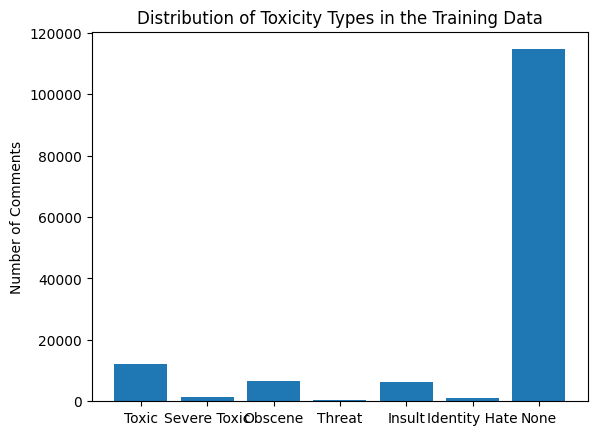

In [ ]:
toxic_train = train_data[train_data['toxic'] == 1]
severe_toxic_train = train_data[train_data['severe_toxic'] == 1]
obscene_train = train_data[train_data['obscene'] == 1]
threat_train = train_data[train_data['threat'] == 1]
insult_train = train_data[train_data['insult'] == 1]
identity_train = train_data[train_data['identity_hate'] == 1]
none_train = train_data[(train_data['identity_hate'] == 0) & (train_data['insult'] == 0) & (train_data['threat'] == 0) &
                        (train_data['obscene'] == 0) & (train_data['severe_toxic'] == 0) & (train_data['toxic'] == 0)]

labels = ['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate', 'None']
counts = [toxic_train.shape[0], severe_toxic_train.shape[0], obscene_train.shape[0], threat_train.shape[0], insult_train.shape[0], identity_train.shape[0], none_train.shape[0]]

plt.bar(labels, counts)
plt.ylabel('Number of Comments')
plt.title('Distribution of Toxicity Types in the Training Data')
plt.show()


# **Balancing the dataset**

* Although the dataset is highly imbalanced it represents real world data. That the pattern that we see in the real world.

* However training the model on such unbalanced dataset would lead to bad performance hence it is important to Fine tune the model of relativly balanced dataset.

* Since the fine tuning of LLMs require high computation require really high computation power. Due to lack of computation units we decrease the traning dataset to 7400 examples with relativly balanced distribution. The graph is given below

In [ ]:
toxic_train = train_data[train_data['toxic'] == 1].head(1500)
severe_toxic_train = train_data[train_data['severe_toxic'] == 1].head(1000)
obscene_train = train_data[train_data['obscene'] == 1].head(1000)
threat_train = train_data[train_data['threat'] == 1].head(400)
insult_train = train_data[train_data['insult'] == 1].head(1000)
identity_train = train_data[train_data['identity_hate'] == 1].head(1000)
none_train = train_data[(train_data['identity_hate'] == 0) & (train_data['insult'] == 0) & (train_data['threat'] == 0) &
                        (train_data['obscene'] == 0) & (train_data['severe_toxic'] == 0) & (train_data['toxic'] == 0)].head(1500)

balanced_train = pd.concat([toxic_train, severe_toxic_train, obscene_train, threat_train, insult_train, identity_train, none_train])

balanced_train.reset_index(drop=True, inplace=True)

balanced_train = balanced_train.sample(frac=1 , random_state=42)


labels = ['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate', 'None']
counts = [toxic_train.shape[0], severe_toxic_train.shape[0], obscene_train.shape[0], threat_train.shape[0], insult_train.shape[0], identity_train.shape[0], none_train.shape[0]]

plt.bar(labels, counts)
plt.ylabel('Number of Comments')
plt.title('Distribution of Toxicity Types in the Balanced Data')
plt.show()


print(f"balance_train shape: {balanced_train.shape}")
balanced_train



balance_train shape: (7400, 8)


id                                       comment_text  \
4698  f8b05b9ae771fb50  Are all professors of rhetoric pompous, self-c...   
5058  24d2b50726b67167  I am going to murder ZimZalaBim ST47 for being...   
7318  2bd4e7d3f2072c25  Eward, If you have a problem with my edits at ...   
169   ad2bb23019f3654b  If you've lived in Fairfield County since colo...   
1952  31ca6d8cf326b643  tbjablins comment above \n\nyou dam nazi! go s...   
...                ...                                                ...   
5191  6f91db77d5fbb3c3  Hi will, are you a nigger by any chance? I am ...   
5226  11885f5165cbbd4e                    FUCK YOURSELVES NAZI MODERATORS   
5390  19530efc92f73e1a  that sock is Mr Putnam alias Khoikhoi, I'm als...   
860   a20c40c84c1bb19d  Are you? \n\nAs gay as danski? if you are I wi...   
7270  8f0efe8ad9a3078e  "\n\nProposed deletion\nWP:PROD is for deletio...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate  
4698      1             0        1       0       1              0  
5058      1             1        1       1       1              1  
7318      0             0        0       0       0              0  
169       1             0        0       0       0              0  
1952      1             1        1       0       1              1  
...     ...           ...      ...     ...     ...            ...  
5191      0             0        0       0       1              1  
5226      1             0        1       0       1              1  
5390      1             0        0       0       0              1  
860       1             0        0       0       1              1  
7270      0             0        0       0       0              0  

[7400 rows x 8 columns]